In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib

In [48]:
INDICATOR_DATASET = False

In [49]:
if INDICATOR_DATASET:
    d = joblib.load('nifty_data.pkl')
else:
    d = yf.download(
                tickers="^NSEI",
                period='max',
                interval='1d',
                progress=False,
                timeout=10
            )
    d['target'] = d.Open/d.Close.shift(-1)
    d.target = d.target.apply(np.floor)
    d.dropna(inplace=True)
    d.tail()

In [50]:
if INDICATOR_DATASET:
    x = d.drop(columns=['target'])
    y = d.target
else:
    x = d.drop(columns=['target', 'Adj Close', 'Volume'])
    y = d.target

In [51]:
x

,Open,High,Low,Close
Date,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805
...,...,...,...,...
2022-09-02,17598.400391,17643.849609,17476.449219,17539.449219
2022-09-05,17546.449219,17683.150391,17540.349609,17665.800781
2022-09-06,17695.699219,17764.650391,17587.650391,17655.599609


In [52]:
y

Date
2007-09-17    0.0
2007-09-18    0.0
2007-09-19    0.0
2007-09-20    0.0
2007-09-21    0.0
             ... 
2022-09-02    0.0
2022-09-05    0.0
2022-09-06    1.0
2022-09-07    0.0
2022-09-08    0.0
Name: target, Length: 3669, dtype: float64

In [53]:
print('No. of Bullish samples: {}'.format(y[y == 0].size))
print('No. of Bearish samples: {}'.format(y[y == 1].size))

No. of Bullish samples: 1873
No. of Bearish samples: 1796


In [54]:
if not INDICATOR_DATASET:
    print("Using StandardScaler")
    scaler = StandardScaler()
    x = scaler.fit_transform(x.to_numpy())
    x
else:
    print("Using ColumnTransformer")
    col_names = ['Open', 'High', 'Low', 'Close', 'ATR']
    scaler = ColumnTransformer(
        [('StandardScaler', StandardScaler(), col_names)],
        remainder='passthrough'
    )
    x = scaler.fit_transform(x)
x

Using StandardScaler


array([[-1.04775797, -1.05034425, -1.0451754 , -1.05342868],
       [-1.05422012, -1.04961627, -1.04552215, -1.0397368 ],
       [-1.03931878, -1.00006055, -1.02720167, -0.99029494],
       ...,
       [ 2.44928572,  2.44809545,  2.44951912,  2.44215132],
       [ 2.40249866,  2.41794369,  2.42195859,  2.43386473],
       [ 2.46320547,  2.45947843,  2.47733279,  2.48017241]])

In [55]:
import tensorflow as tf
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.optimizers import SGD
import keras

units = 1024
sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'

callback_mc = keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                verbose=1,
                monitor='val_accuracy',
                save_best_only=True,
                mode='auto'
                )
callback_es = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='auto',
                verbose=0,
                patience=100
)

model = Sequential([
    Dense(units, kernel_initializer=kernel_init, activation=activation, input_dim=x.shape[1]),
    # Dense(units, kernel_initializer=kernel_init, activation=activation),
    Dense(units//2, kernel_initializer=kernel_init, activation=activation),
    Dense(units//4, kernel_initializer=kernel_init, activation=activation),
    Dense(units//8, kernel_initializer=kernel_init, activation=activation),
    Dense(units//16, kernel_initializer=kernel_init, activation=activation),
    Dense(units//32, kernel_initializer=kernel_init, activation=activation),
    Dense(1, kernel_initializer=kernel_init, activation='sigmoid'),
])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              5120      
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                

In [ ]:
history = model.fit(x, y, callbacks=[callback_mc, callback_es], batch_size=4, epochs=500, validation_split=0.3, verbose=2)

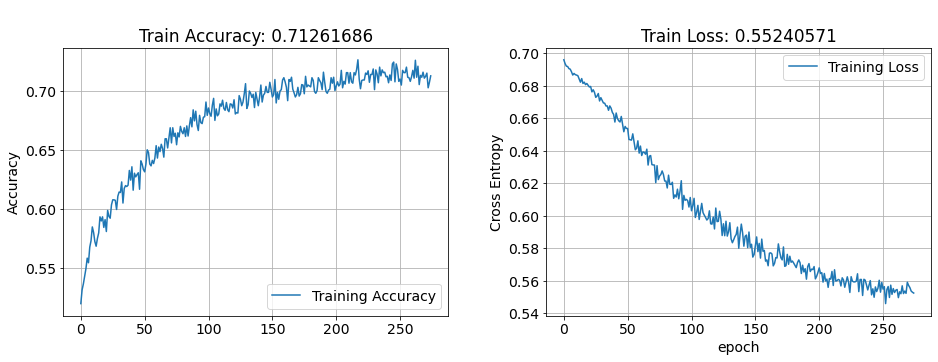

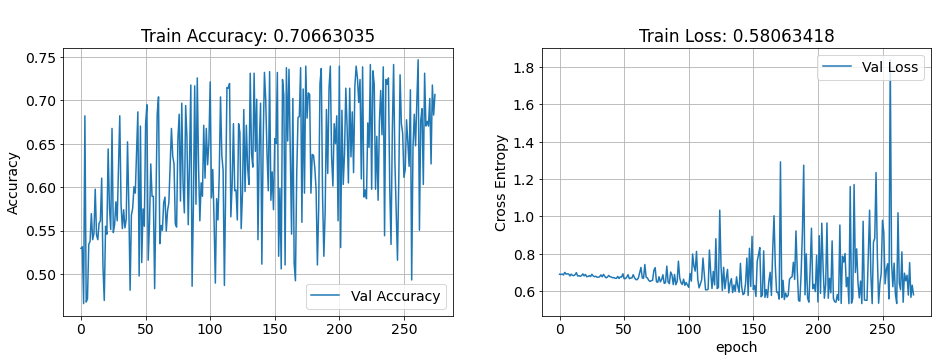

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(14,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTrain Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTrain Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

acc = history.history['val_accuracy']
loss = history.history['val_loss']

plt.figure(figsize=(14,6))
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTrain Accuracy: {round(acc[-1],8)}')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'\nTrain Loss: {round(loss[-1],8)}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Try Realtime Inference

In [44]:
endpoint = keras.models.load_model('best_model_0.7465acc.h5')
today = yf.download(
                tickers="^NSEI",
                period='100d',
                interval='1d',
                progress=False,
                timeout=10
            )
today = today.drop(columns=['Adj Close', 'Volume'])

cnt_correct, cnt_wrong = 0, 0
for i in range(-100,0):
    df = today.iloc[i]
    twr = today.iloc[i+1]['Close']
    df = scaler.transform([df])
    pred = endpoint.predict([df], verbose=0)

    if twr > today.iloc[i]['Open']:
        fact = "BULLISH"
    else:
        fact = "BEARISH"

    if pred > 0.5:
        out = "BEARISH"
    else:
        out = "BULLISH"

    if out == fact:
        cnt_correct += 1
    else:
        cnt_wrong += 1
        
    print("{} Nifty Prediction -> Market may Close {} on {}! Actual -> {}, Prediction -> {}".format(
            today.iloc[i].name.strftime("%d-%m-%Y"),
            out,
            (today.iloc[i].name + pd.Timedelta(days=1)).strftime("%d-%m-%Y"),
            fact,
            "Correct" if fact == out else "Wrong"
            )
        )

print("Correct: {}, Wrong: {}, Accuracy: {}".format(cnt_correct, cnt_wrong, cnt_correct/(cnt_correct+cnt_wrong)))

2022-09-10 11:40:06.316033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19-04-2022 Nifty Prediction -> Market may Close BEARISH on 20-04-2022! Actual -> BEARISH, Prediction -> Correct
20-04-2022 Nifty Prediction -> Market may Close BULLISH on 21-04-2022! Actual -> BULLISH, Prediction -> Correct
21-04-2022 Nifty Prediction -> Market may Close BULLISH on 22-04-2022! Actual -> BEARISH, Prediction -> Wrong
22-04-2022 Nifty Prediction -> Market may Close BEARISH on 23-04-2022! Actual -> BEARISH, Prediction -> Correct
25-04-2022 Nifty Prediction -> Market may Close BEARISH on 26-04-2022! Actual -> BULLISH, Prediction -> Wrong
26-04-2022 Nifty Prediction -> Market may Close BULLISH on 27-04-2022! Actual -> BEARISH, Prediction -> Wrong
27-04-2022 Nifty Prediction -> Market may Close BEARISH on 28-04-2022! Actual -> BULLISH, Prediction -> Wrong
28-04-2022 Nifty Prediction -> Market may Close BULLISH on 29-04-2022! Actual -> BEARISH, Prediction -> Wrong
29-04-2022 Nifty Prediction -> Market may Close BEARISH on 30-04-2022! Actual -> BEARISH, Prediction -> Correct
02

## Save Model for Screeni-py integration

In [45]:
pkl = {
    #  'model': model,
    'scaler': scaler,
    'columns': ['Open', 'Close', 'High', 'Low']
}

joblib.dump(pkl, 'nifty_model.pkl')

INFO:tensorflow:Assets written to: ram://6c18a1c6-69e5-49ab-935c-8f4d8968670e/assets


['nifty_model.pkl']

In [3]:
pkl = joblib.load('nifty_model.pkl')
z = yf.download(
                tickers="^NSEI",
                period='1d',
                interval='1d',
                progress=False,
                timeout=10
            )
z = z.iloc[-1]
z = z[pkl['columns']]
z = pkl['scaler'].transform([z])
pkl['model'].predict(z)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-12 10:11:03.618721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-12 10:11:03.618978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 [==============================] - 0s 104ms/step


2022-09-12 10:11:04.299350: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-12 10:11:04.350683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.6690634]], dtype=float32)

In [4]:
pkl['model'].save('nifty_model.h5')

In [5]:
pkl

{'model': <keras.engine.sequential.Sequential at 0x17d91e8e0>,
 'scaler': StandardScaler(),
 'columns': ['Open', 'Close', 'High', 'Low']}

In [6]:
del pkl['model']

In [7]:
pkl

{'scaler': StandardScaler(), 'columns': ['Open', 'Close', 'High', 'Low']}